# Image Stacking 

Primero vemos alguna imagen antes de aplicar el apilamiento de ellas:

In [13]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [15]:
EXTENSIONS = set(["bmp", "jpeg", "jpg", "png", "tif", "tiff"])

src_dir = "Muestra2"
src_contents = os.walk(src_dir)
dirpath, _, fnames = next(src_contents)

image_dir = os.path.split(dirpath)[-1]

print("Processing '" + image_dir + "' folder...")

image_files = sorted([os.path.join(dirpath, name) for name in fnames])
image_files = [cv2.imread(name) for name in image_files
          if os.path.splitext(name)[-1][1:].lower() in EXTENSIONS]

if any([image is None for image in image_files]):
    raise RuntimeError("One or more input files failed to load.")
print(image_dir + " folder is ready")

Processing 'Muestra2' folder...
Muestra2 folder is ready


Image 0


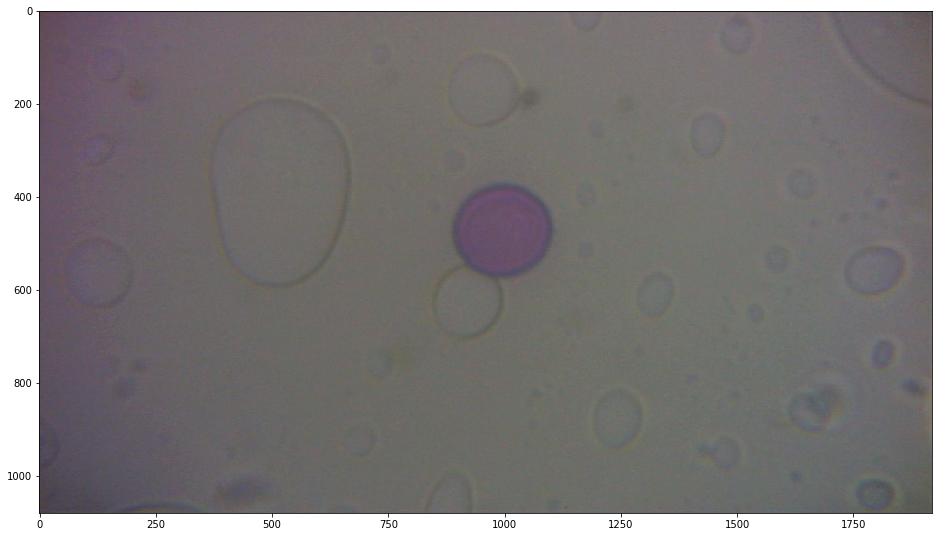

In [16]:
plt.figure(figsize=(16,11))
print('Image 0')
plt.imshow(cv2.cvtColor(image_files[0], cv2.COLOR_BGR2RGB))
plt.show()

Image 6


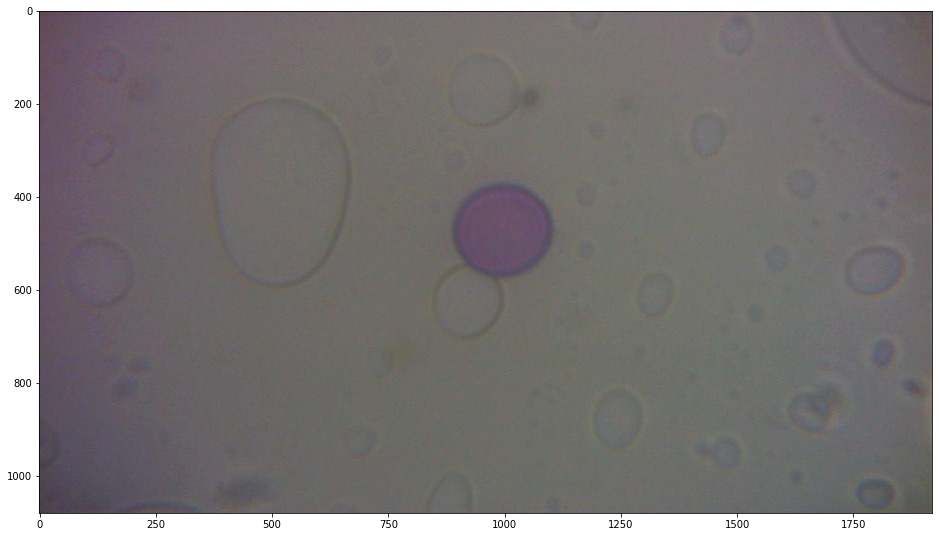

In [17]:
plt.figure(figsize=(16,11))
print('Image 6')
plt.imshow(cv2.cvtColor(image_files[7], cv2.COLOR_BGR2RGB))
plt.show()

### Algoritmo de Image Stacking:

In [18]:
import os
import cv2
import numpy as np
from time import time



# Align and stack images with ECC method
# Slower but more accurate
def stackImagesECC(file_list):
    M = np.eye(3, 3, dtype=np.float32)

    first_image = None
    stacked_image = None

    for file in file_list:
        image = cv2.imread(file,1).astype(np.float32) / 255
        print(file)
        if first_image is None:
            # convert to gray scale floating point image
            first_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            stacked_image = image
        else:
            # Estimate perspective transform
            s, M = cv2.findTransformECC(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY), first_image, M, cv2.MOTION_HOMOGRAPHY)
            w, h, _ = image.shape
            # Align image to first image
            image = cv2.warpPerspective(image, M, (h, w))
            stacked_image += image

    stacked_image /= len(file_list)
    stacked_image = (stacked_image*255).astype(np.uint8)
    return stacked_image


# Align and stack images by matching ORB keypoints
# Faster but less accurate
def stackImagesKeypointMatching(file_list):

    orb = cv2.ORB_create()

    # disable OpenCL to because of bug in ORB in OpenCV 3.1
    cv2.ocl.setUseOpenCL(False)

    stacked_image = None
    first_image = None
    first_kp = None
    first_des = None
    for file in file_list:
        print(file)
        image = cv2.imread(file,1)
        imageF = image.astype(np.float32) / 255

        # compute the descriptors with ORB
        kp = orb.detect(image, None)
        kp, des = orb.compute(image, kp)

        # create BFMatcher object
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        if first_image is None:
            # Save keypoints for first image
            stacked_image = imageF
            first_image = image
            first_kp = kp
            first_des = des
        else:
             # Find matches and sort them in the order of their distance
            matches = matcher.match(first_des, des)
            matches = sorted(matches, key=lambda x: x.distance)

            src_pts = np.float32(
                [first_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32(
                [kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            # Estimate perspective transformation
            M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            w, h, _ = imageF.shape
            imageF = cv2.warpPerspective(imageF, M, (h, w))
            stacked_image += imageF

    stacked_image /= len(file_list)
    stacked_image = (stacked_image*255).astype(np.uint8)
    return stacked_image

### Cargamos el directorio:

In [19]:
image_folder = "Muestra2"
if not os.path.exists(image_folder):
    print("ERROR {} not found!".format(image_folder))
    exit()
file_list = os.listdir(image_folder)
file_list = [os.path.join(image_folder, x)
            for x in file_list if x.endswith(('.jpg', '.png','.bmp'))]
print(image_folder + " folder is ready")

Muestra2 folder is ready


### Method matching ORB keypoints

In [26]:
stacked_image = stackImagesKeypointMatching(file_list)

Muestra2\10.jpg
Muestra2\11.jpg


error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\calib3d\src\ptsetreg.cpp:169: error: (-215:Assertion failed) count >= 0 && count2 == count in function 'cv::RANSACPointSetRegistrator::run'


In [25]:
#Save image
cv2.imwrite('stacked_img_ORBresult.jpg',stacked_image)
#Show image
description = "Stacking images using ORB method"
#cv2.imshow(description, stacked_image)
#cv2.waitKey(0)#Permite pausar la ejecución del programa hasta que el usuario presione una tecla.

stacked_img_ORBresult


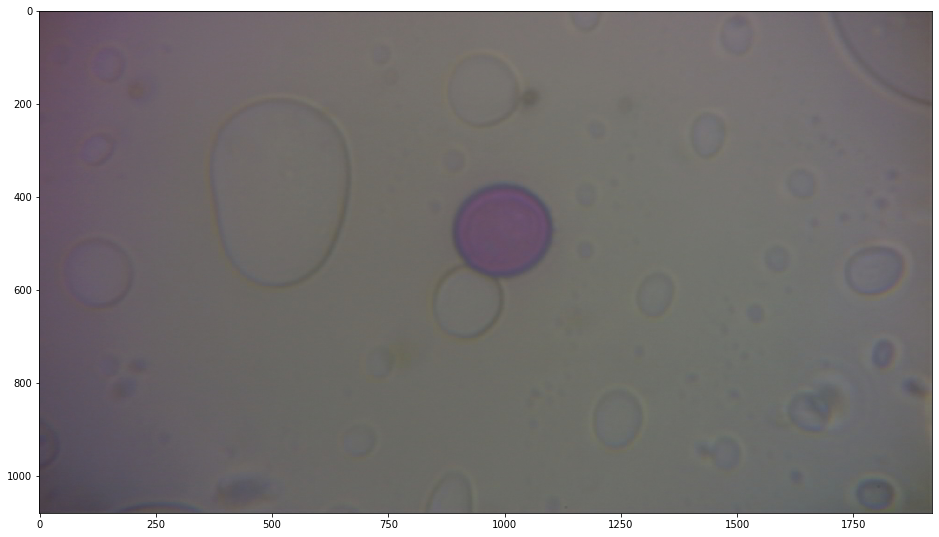

In [27]:
###################################################################
###### Se representa la imagen guardada con el resultado ECC ######
###################################################################
image_file_ECC = cv2.imread('stacked_img_ORBresult.jpg')
plt.figure(figsize=(16,11))
print('stacked_img_ORBresult')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()

### Method ECC

In [22]:
stacked_image = stackImagesECC(file_list)

Muestra2\10.jpg
Muestra2\11.jpg
Muestra2\12.jpg
Muestra2\13.jpg
Muestra2\14.jpg
Muestra2\15.jpg
Muestra2\16.jpg
Muestra2\2.jpg
Muestra2\3.jpg
Muestra2\4.jpg
Muestra2\5.jpg
Muestra2\6.jpg
Muestra2\7.jpg
Muestra2\8.jpg
Muestra2\9.jpg


In [23]:
#Save image
cv2.imwrite('Muestra2_ECCresult.jpg',stacked_image)
#Show image
description = "Stacking images using ECC method"
#cv2.imshow(description, stacked_image)
#cv2.waitKey(0)#Permite pausar la ejecución del programa hasta que el usuario presione una tecla.

stacked_img_ECCresult


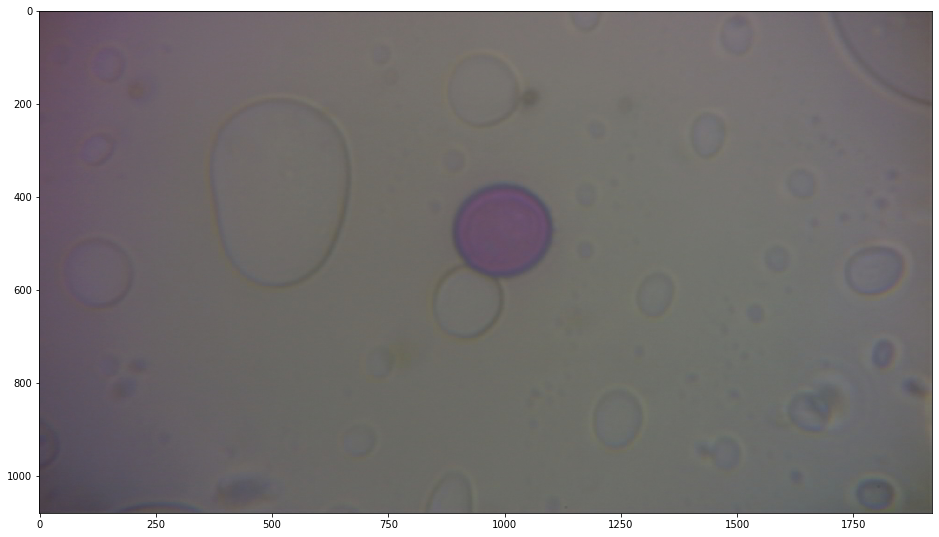

In [24]:
###################################################################
###### Se representa la imagen guardada con el resultado ECC ######
###################################################################
image_file_ECC = cv2.imread('Muestra2_ECCresult.jpg')
plt.figure(figsize=(16,11))
print('stacked_img_ECCresult')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()

### Comparativa

stacked_img_ECCresult_zoom


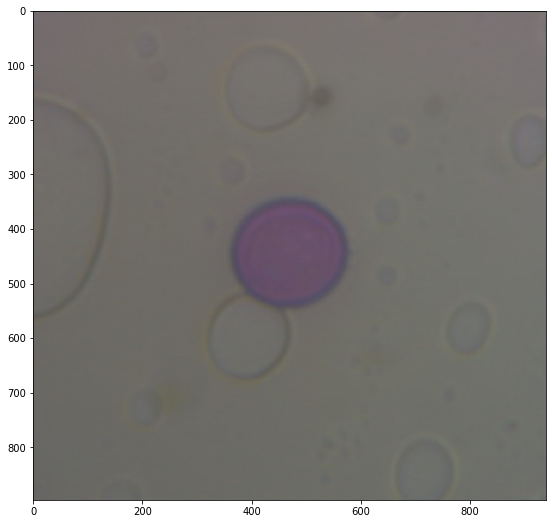

polen_ruido


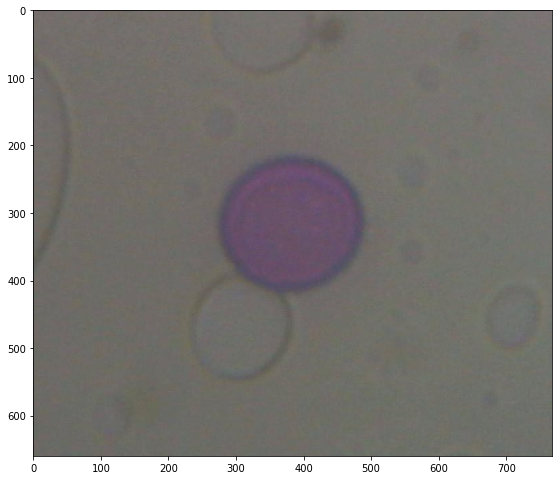

In [32]:
image_file_ECC = cv2.imread('Muestra2_ECCresult_zoom.jpg')
plt.figure(figsize=(14,9))
print('stacked_img_ECCresult_zoom')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()
#################################################################
image_file_ECC = cv2.imread('5_zoom.jpg')
plt.figure(figsize=(13,8.2))
print('polen_ruido')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()